<파이썬 머신러닝 완벽가이드 개정 2판> ch 9. 7~9 p.625-647
___
# CHAPTER 09. 추천 시스템 (Recommendations)
#### 09-07. 행렬 분해를 이용한 잠재 요인 협업 필터링 실습

#### 09-08. 파이썬 추천 시스템 패키지 - Surprise
   - Surprise 패키지 소개
   - Surprise를 이용한 추천 시스템 구축
   - Surprise 주요 모듈 소개
   - Surprise 추천 알고리즘 클래스
   - 베이스라인 평점
   - 교차검정과 하이퍼 파라미터 튜닝
   - Surprise를 이용한 개인화 영화 추천 시스템 구축
   ___

## 09-07. 행렬 분해를 이용한 잠재 요인 협업 필터링 실습

- **확률적 경사 하강법**을 이용한 행렬 분해
  - Key Idea: 원본 행렬 R에서 null값이 아닌 실질값이 입력된 데이터만을 이용해 P와 Q를 반복해서 업데이트함으로써 P와 Q 행렬을 완성하고 이렇게 추출된 P와 Q를 내적하면 원래는 null이었던 값에 대해서도 예측치를 낼 수 있음.
     - 여기서 업데이트 기준이 되는 비용 함수식은 실제값 R과 예측값 사이 오류 최소화와 L2 규제를 고려함.
  - 단계
    1. 초기 P와 Q 행렬
    2. 비용값 e 계산
    3.
     
     P' = P + (SGD 학습률) * (e * Q - (L2 규제 계수) * P)
     
      Q' = Q + (SGD 학습률) * (e * P - (L2 규제 계수) * Q)

     식을 적용하여 P와 Q 업데이트
    4. 위 단계를 반복. 지정된 step 개수만큼.




In [5]:
# 실제 R 행렬과 예측행렬의 오차를 구하는 get_rmse() 함수
import numpy as np
from sklearn.metrics import mean_squared_error

def get_rmse(R, P, Q, non_zeros):
  error = 0
  # 두 개의 분해된 행렬 P와 Q.T의 내적으로 예측 R 행렬 생성
  full_pred_matrix = np.dot(P, Q.T)

  # 실제 R 행렬에서 null이 아닌 값의 위치 인덱스를 추출해 실제 R 행렬과 예측 행렬의 RMSE 추출
  X_non_zeros_ind = [non_zero[0] for non_zero in non_zeros]
  y_non_zeros_ind = [non_zero[1] for non_zero in non_zeros]
  R_non_zeros = R[X_non_zeros_ind, y_non_zeros_ind]
  full_pred_matrix_non_zeros = full_pred_matrix[X_non_zeros_ind, y_non_zeros_ind]
  mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
  rmse = np.sqrt(mse)

  return rmse

- matrix_factorization 함수
   - 입력값
      - `R` : 원본 사용자-아이템 평점 행렬
      - `K` : 잠재 요인의 차원 수
      - `steps` : SGD 반복 횟수
      - `learning_rate` : 학습률
      - `t_lambda` : L2 규제 계수
   - 단계
      1. `P`와 `Q`를 정규분포를 가진 랜덤한 값으로 입력 (무작위 초기화)
      2. 평점이 0 이상인 행, 열의 위치와 값을 리스트 객체에 저장
      3. SGD 기법으로 오차인 `eij` 값, `P`와 `Q` 행렬을 계속 업데이트
   - 출력값
      - `P`: 사용자 잠재요인 행렬 (사용자 수 x 잠재요인 차원수)
      - `Q`: 아이템 잠재요인 행렬 (아이템 수 x 잠재요인 차원수)

In [6]:
def matrix_factorization(R, K, steps=200, learning_rate=0.01, r_lambda=0.01):
  num_users, num_items = R.shape
  # P와 Q 매트릭스의 크기를 지정하고 정규분포를 가진 랜덤한 값으로 입력
  np.random.seed(1)
  P = np.random.normal(scale=1./K, size=(num_users, K))
  Q = np.random.normal(scale=1./K, size=(num_items, K))

  # R>0인 행의 위치, 열의 위치, 값을 non_zeros 리스트 객체에 저장
  non_zeros = [(i, j, R[i, j]) for i in range(num_users) for j in range(num_items) if R[i, j]>0]

  # SGD 기법으로 P와 Q 매트릭스를 계속 업데이트
  for step in range(steps):
    for i, j, r in non_zeros:
      # 실제값과 예측값의 차이인 오류 값 구하기
      eij = r - np.dot(P[i,:], Q[j,:].T)
      # Regularization을 반영한 SGD 업데이터 공식 적용
      P[i,:] = P[i,:] + learning_rate * (eij * Q[j,:] - r_lambda * P[i,:])
      Q[j,:] = Q[j,:] + learning_rate * (eij * P[i,:] - r_lambda * Q[j,:])

    rmse = get_rmse(R, P, Q, non_zeros)
    # step 10번마다 rmse값 추출
    if (step % 10) == 0:
      print('### iteration step : ', step, 'rmse : ', rmse)

  # step을 전부 돌고 난 후 행렬 분해된 P와 Q 행렬 리턴
  return P, Q

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import pandas as pd
import numpy as np

movies = pd.read_csv('/content/drive/MyDrive/ESAA_OB/Dataset/movies.csv')
ratings = pd.read_csv('/content/drive/MyDrive/ESAA_OB/Dataset/ratings.csv')
ratings = ratings[['userId', 'movieId', 'rating']]
ratings_matrix = ratings.pivot_table('rating', index='userId', columns='movieId')

# title 칼럼을 얻기 위해 movies와 조인 수행
ratings_movies = pd.merge(ratings, movies, on='movieId')

# columns='title'로 title 칼럼으로 pivot 수행
ratings_matrix = ratings_movies.pivot_table('rating', index='userId', columns='title')

- 원본 사용자-아이템 평점 행렬을 사용자의 잠재요인 행렬과 아이템의 잠재요인 행렬로 분해
   - matrix_factorization( ) 함수 이용
     - 잠재요인 차원 수 = 50
     - 반복 횟수 = 200
     - 학습률 = 0.01
     - L2 규제 계수 = 0.01


In [12]:
# 사용자-아이템 평점 행렬 ratings_matrix를 행렬 분해하기
P, Q = matrix_factorization(ratings_matrix.values, K=50, steps=200,
                            learning_rate=0.01, r_lambda=0.01)
pred_matrix = np.dot(P, Q.T)

### iteration step :  0 rmse :  2.9023619751336867
### iteration step :  10 rmse :  0.7335768591017927
### iteration step :  20 rmse :  0.5115539026853442
### iteration step :  30 rmse :  0.37261628282537446
### iteration step :  40 rmse :  0.2960818299181014
### iteration step :  50 rmse :  0.2520353192341642
### iteration step :  60 rmse :  0.22487503275269854
### iteration step :  70 rmse :  0.2068545530233154
### iteration step :  80 rmse :  0.19413418783028685
### iteration step :  90 rmse :  0.18470082002720406
### iteration step :  100 rmse :  0.17742927527209104
### iteration step :  110 rmse :  0.1716522696470749
### iteration step :  120 rmse :  0.16695181946871726
### iteration step :  130 rmse :  0.16305292191997542
### iteration step :  140 rmse :  0.15976691929679646
### iteration step :  150 rmse :  0.1569598699945732
### iteration step :  160 rmse :  0.15453398186715425
### iteration step :  170 rmse :  0.15241618551077643
### iteration step :  180 rmse :  0.15055080739

In [13]:
# 예측된 사용자-아이템 평점 행렬, 영화 제목을 칼럼명으로 갖는 DataFrame 생성
ratings_pred_matrix = pd.DataFrame(data=pred_matrix, index=ratings_matrix.index,
                                   columns=ratings_matrix.columns)
ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,3.055084,4.092018,3.564130,4.502167,3.981215,1.271694,3.603274,2.333266,5.091749,3.972454,...,1.402608,4.208382,3.705957,2.720514,2.787331,3.475076,3.253458,2.161087,4.010495,0.859474
2,3.170119,3.657992,3.308707,4.166521,4.311890,1.275469,4.237972,1.900366,3.392859,3.647421,...,0.973811,3.528264,3.361532,2.672535,2.404456,4.232789,2.911602,1.634576,4.135735,0.725684
3,2.307073,1.658853,1.443538,2.208859,2.229486,0.780760,1.997043,0.924908,2.970700,2.551446,...,0.520354,1.709494,2.281596,1.782833,1.635173,1.323276,2.887580,1.042618,2.293890,0.396941


- 예측 사용자-아이템 평점 행렬을 이용해 개인화된 영화 추천
   1. 사용자 9번이 관람하지 않은 영화 리스트를 추출
   2. 잠재 요인을 기반으로 예측된 예측 평점 행렬을 이용해 평점 상위 10개의 영화 추출
   3. 영화 10개의 이름과 예측 평점을 DataFrame으로 정리하여 확인

In [14]:
def get_unseen_movies(ratings_matrix, userId):
    # userId로 입력받은 사용자의 모든 영화정보 추출하여 Series로 반환함.
    # 반환된 user_rating 은 영화명(title)을 index로 가지는 Series 객체임.
    user_rating = ratings_matrix.loc[userId,:]

    # user_rating이 0보다 크면 기존에 관람한 영화임. 대상 index를 추출하여 list 객체로 만듬
    already_seen = user_rating[ user_rating > 0].index.tolist()

    # 모든 영화명을 list 객체로 만듬.
    movies_list = ratings_matrix.columns.tolist()

    # list comprehension으로 already_seen에 해당하는 movie는 movies_list에서 제외함.
    unseen_list = [ movie for movie in movies_list if movie not in already_seen]

    return unseen_list


In [15]:
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n=10):
    # 예측 평점 DataFrame에서 사용자id index와 unseen_list로 들어온 영화명 컬럼을 추출하여
    # 가장 예측 평점이 높은 순으로 정렬함.
    recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    return recomm_movies

In [16]:
# 사용자 9번이 관람하지 않은 영화명 추출
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 잠재요인 협업 필터링으로 영화 추천
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)

# 추천 영화와 그의 평점 데이터를 DataFrame으로 생성
recomm_movies = pd.DataFrame(data=recomm_movies.values, index=recomm_movies.index,
                             columns=['pred_score'])
recomm_movies

,pred_score
title,
Rear Window (1954),5.704612
"South Park: Bigger, Longer and Uncut (1999)",5.451100
Rounders (1998),5.298393
Blade Runner (1982),5.244951
Roger & Me (1989),5.191962
Gattaca (1997),5.183179
Ben-Hur (1959),5.130463
Rosencrantz and Guildenstern Are Dead (1990),5.087375
"Big Lebowski, The (1998)",5.038690


- 아이템 기반 협업 필터링을 이용해 추천된 영화와는 많이 다른 결과가 보임.
- 약간 어둡고 무거운 주제의 영화가 추천됨.

## 09-08. 파이썬 추천 시스템 패키지 - Surprise


### Surprise 패키지 소개

Surprise란? 파이썬 기반의 추천 시스템 구축을 위한 전용 패키지 중 하나

- API를 이용해 다양한 추천 알고리즘(사용자/아이템 기반 최근접 이웃 협업 필터링, SVD, SVD++, NMF 기반의 잠재 요인 협업 필터링)을 쉽게 적용해 추천 시스템 구축 가능
- 사이킷런과 유사한 API명으로 작성됨.
   - (eg.) fit( ), predict( ), train_test_split( ), cross_validate( )

In [17]:
pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505213 sha256=84284f60510d341488c2caa034c7f62e33d97ab01a1abae2c5a6ebdf54450c9d
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


###Surprise를 이용한 추천 시스템 구축
1. 데이터 로딩
   - Dataset 클래스로만 가능
   - 주요 데이터가 로우(row) 레벨 형태로 되어있는 포멧의 데이터만 처리
   - 데이터의 첫번째 칼럼을 사용자 아이디, 두번째 칼럼을 아이템 아이디, 세번째 칼럼을 평점으로 가정한채로 로딩하고, 네번째 칼럼부터는 아예 로딩 수행 X.





 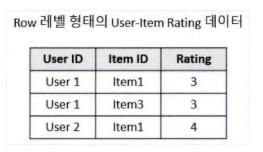

2. 추천을 예측
   - `test()` 메서드:
      - 전체 데이터 세트에 대해서 추천을 예측. predict()를 반복적으로 수행한 결과라고 생각.
      - 호출 시 반환되는 리스트 객체는 데이터의 개수만큼 Prediction 객체를 내부에 포함.
      - Prediction 객체: 패키지 자체에서 제공하는 데이터 타입
         - `Prediction(uid='120',
iid='282, r_ui=4.0, est=3.5114147666251547, details={'was.impossible'：False})`의 속성
         - `uid`: user id
         - `iid`: item id
         - `r_ui`: 실제 평점 값
         - `est`: 예측 평점 값
         - `details`: 예측값을 생성할 수 있었는지의 여부. 예측 불가능 시 로그용으로 데이터를 남기는데에 사용됨.
   - `predict()` 메서드:
      - 개별 사용자와 영화에 대한 추천 평점을 반환
      - 사용자 아이디, 아이템 아이디를 문자열로 입력해야함을 주의.
3. 추천 시스템의 성능 평가
   - 추천 예측 평점과 실제 평점과의 차이를 평가
   - accuracy 모듈의 `mse`, `rmse()` 메서드

###Surprise 주요 모듈 소개
#### Dataset의 API  
- **`Dataset.load_builtin(name='ml-100k')`**
   - 무비렌즈 아카이브 FTP 서버에서 무비렌즈 데이터를 내려받음.
   - name 파라미터로 'ml-100k'(10만개 평점 데이터) 또는 'm1-1m'(100만 개 평점 데이터) 설정 가능
   - Surprise가 내려받은 ml-100k, ml-1m은 과거 버전의 데이터 세트
   - 과거 버전의 데이터 파일은 분리 문자가 탭(\t) 문자
- **`Dataset.load_from_file(file_path, reader)`**
   - OS 파일에서 데이터 로딩할 때 사용
   - 로딩되는 데이터 파일에 칼럼명 Header을 제거해야함.




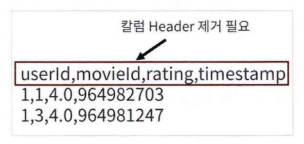

- **`Dataset.load_from_df(df, reader)`**
   - pandas의 DataFrame에서 데이터를 로딩할 때 사용
   - 3개의 칼럼이 반드시 사용자 아이디, 아이템 아이디, 평점 순으로 정렬되어 있어야 함.

- reader: 로딩될 파일의 파싱 정보를 알려주기 위해 사용됨.
   - Reader 클래스의 객체
   - 주요 생성 파라미터

    `line_format`: 칼럼명을 순서대로 나열. 공백으로 분리.
      
      `sep`: 칼럼을 분리하는 분리자. 디폴트는 '\t'. DataFrame 로딩 시 따로 입력할 필요없음.
      
      `rating_scale`: 평점의 (최솟값, 최댓값)




#### 무비렌즈 아카이브 FTP 서버에서 무비렌즈 데이터 로딩

In [1]:
pip install numpy==1.24.4

In [2]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

In [4]:
# MovieLens 사이트에서 제공하는 과거 버전의 데이터 세트인 'ml-100k'를 내려받음.
data = Dataset.load_builtin('ml-100k')
# 수행 시마다 동이랗게 데이터를 분할하기 위해 random_state 값 부여
trainset, testset = train_test_split(data, test_size=0.25, random_state=0)

Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


In [6]:
# 학습 데이터 세트 기반으로 추천 알고리즘 학습
algo = SVD(random_state=0)
algo.fit(trainset)

- `test()` 메서드


In [7]:
# test() 메서드
predictions = algo.test(testset)
print('prediction type:', type(predictions), 'size:', len(predictions))
print('prediction 결과의 최초 5개 추출')
predictions[:5]

prediction type: <class 'list'> size: 25000
prediction 결과의 최초 5개 추출


[Prediction(uid='120', iid='282', r_ui=4.0, est=3.5114147666251547, details={'was_impossible': False}),
 Prediction(uid='882', iid='291', r_ui=4.0, est=3.573872419581491, details={'was_impossible': False}),
 Prediction(uid='535', iid='507', r_ui=5.0, est=4.033583485472447, details={'was_impossible': False}),
 Prediction(uid='697', iid='244', r_ui=5.0, est=3.8463639495936905, details={'was_impossible': False}),
 Prediction(uid='751', iid='385', r_ui=4.0, est=3.1807542478219157, details={'was_impossible': False})]

`test` 메서드 호출 결과:
- 파이썬 리스트
- 크기는 입력 인자 데이터 세트의 크기와 동일
- 리스트 내의 25000개의 `prediction` 객체

In [8]:
# 리스트 내의 개별 Prediction 객체의 속성에 접근
[(pred.uid, pred.iid, pred.est) for pred in predictions[:3]]

[('120', '282', 3.5114147666251547),
 ('882', '291', 3.573872419581491),
 ('535', '507', 4.033583485472447)]

- `prediction()` 메서드

In [9]:
# 사용자 아이디, 아이템 아이디를 문자열로 입력해야함.
uid = str(196)
iid = str(302)
pred = algo.predict(uid, iid)
print(pred)

user: 196        item: 302        r_ui = None   est = 4.49   {'was_impossible': False}


사용자 아이디 196번, 아이템 아이디 302번에 대한 예측 평점값은 4.49다.

In [10]:
# RMSE 평가 결과
accuracy.rmse(predictions)

RMSE: 0.9467


0.9466860806937948


####OS 파일 데이터를 Surprise 데이터 세트로 로딩

In [11]:
import pandas as pd
ratings = pd.read_csv('/content/drive/MyDrive/ESAA_OB/Dataset/ratings.csv')

# ratings_noh.csv 파일로 언로드 시 인덱스와 헤더를 모두 제거한 새로운 파일 생성
ratings.to_csv('/content/drive/MyDrive/ESAA_OB/Dataset/ratings_noh.csv', index=False, header=False)

`ratings_noh.csv 파일`은
- 칼럼 헤더가 없고
- 4개의 칼럼이 콤마로만 분리되어 있음.

Reader 객체 생성시
- user, item, rating, timestamp 4개의 칼럼으로 데이터가 구성되어있음을 명시
- 분리 문자는 콤마
- 평점의 단위는 0.5
- 최대 평점은 5로 설정.  

In [13]:
from surprise import Reader

# 로딩될 파일의 파싱 정보를 알려주는 reader 객체 생성
reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5, 5))
data = Dataset.load_from_file('/content/drive/MyDrive/ESAA_OB/Dataset/ratings_noh.csv', reader=reader)

In [14]:
trainset, testset = train_test_split(data, test_size=0.25, random_state=0)

# 잠재요인 크기를 50으로 설정한 SVD 행렬 분해 기법을 사용해 추천 예측
algo = SVD(n_factors=50, random_state=0)

# 학습 데이터 세트로 학습하고 나서 테스트 데이터 세트로 평점 예측 후 RMSE 평가
algo.fit(trainset)
predictions = algo.test(testset)

accuracy.rmse(predictions)

RMSE: 0.8682


0.8681952927143516


####판다스 DataFrame에서 Surprise 데이터 세트로 로딩

In [16]:
import pandas as pd
from surprise import Reader, Dataset

ratings = pd.read_csv('/content/drive/MyDrive/ESAA_OB/Dataset/ratings.csv')
reader = Reader(rating_scale=(0.5, 5.0))

# ratings.csv 파일을 DataFrame으로 로딩. 단, 칼럼은 사용자 아이디, 아이템 아이디, 평점 순서를 지켜야 함.
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25, random_state=0)

# 학습, 예측, 평가
algo = SVD(n_factors=50, random_state=0)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8682


0.8681952927143516

###Surprise 추천 알고리즘 클래스
- SVD: 행렬분해를 통한 잠재요인 협업 필터링을 위한 SVD 알고리즘
   - 비용 함수: 베이스라인 편향성을 감안한 예측에 규제 적용.
      - 사용자 예측 Rating:
      
   $$ \hat{r}_{ui} = \mu + b_u + b_i + \mathbf{q}_i^T \mathbf{p}_u $$
      - 규제를 적용한 비용 함수:
  $$ \sum (r_{ui} - \hat{r}_{ui})^2 + \lambda (b_i^2 + b_u^2 + \| \mathbf{q}_i \|^2 + \| \mathbf{p}_u \|^2) $$
   - 입력 파라미터
      - `n_factors`: 잠재요인 개수. 디폴트 100. 커질수록 정확도는 높아지지만 과적합 문제 발생 가능성.
      - `n_epochs`: SGD 수행 반복횟수. 디폴트 20.
      - `biased`: 베이스라인 적용 여부. 디폴트 True.
- KNNBasic: 최근접 이웃 협업 필터링을 위한 KNN 알고리즘
- BaselineOnly: 사용자 bias와 아이템 bias를 반영한 SGD 기반 베이스라인 알고리즘
- 추천 알고리즘 테스트 결과:  

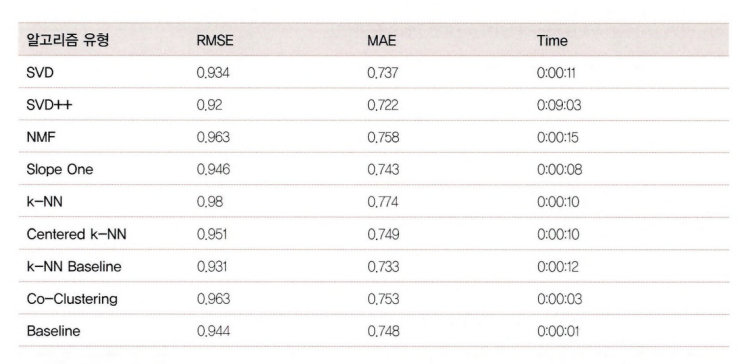

- SVD++: 제일 작은 RMSE, MAE 값으로 성적이 제일 좋지만 시간이 오래 걸려서 사용이 어려움.
- k-NN Baseline, SVD 성능 평가 수치가 좋음.

###베이스라인 평점
- 사용 이유: 사용자 개개인의 성향을 반영해 아이템 평가에 편향성(bias) 요소를 반영하기 위해서.
- 계산 방법:

   평점 =  전체 평균 평점 + 사용자 편향 점수 + 아이템 편향 점수
   - 전체 평균 평점 = 모든 사용자의 아이템에 대한 평점을 평균한 값
   - 사용자 편향 점수 = 사용자별 아이템 평점 평균 값 - 전체 평균 평점
   - 아이템 편향 점수 = 아이템별 평점 평균 값 - 전체 평균 평점



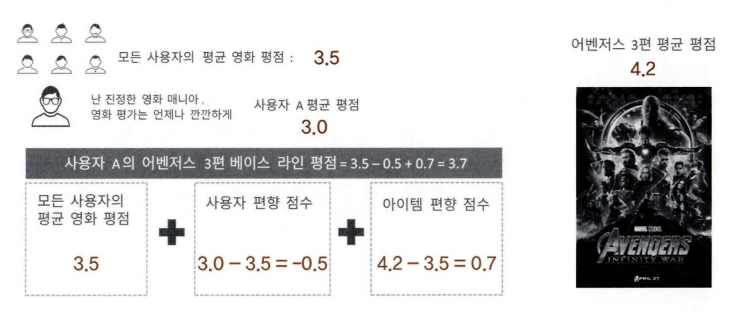

- 사용자 A의 '어벤저스 3'의 베이스라인 평점
   
   = 3.5 (전체 평점의 평균) - 0.5 (사용자 편향 점수) + 0.7 (아이템 편향 점수)

   = 3.7
- 깐깐하게 평가하는 사용자의 성향 & 평균적으로 높은 평점을 기록한 아이템의 성향을 반영.

###교차검정과 하이퍼 파라미터 튜닝
`surprise.model_selection` 모듈 내의
- `cross_validate`:
   - 목적: 데이터를 k개의 학습/검증 폴드 데이터 세트로 분리해 교차 검증을 수행하고 RMSE, MAE로 성능 평가를 진행
   - 결과: 폴드별 성능 평가 수치 + 전체 폴드의 평균 성능 평가 수치
- `GridSearchCV`:
   - 교차 검증을 통한 하이퍼 파라미터 최적화를 수행
   - 사이킷런의 GridSearchCV와 유사
   - SVD의 경우 주로 반복 횟수 `n_epochs`, 잠재요인 차원 수 `n_factors`를 튜닝.

In [18]:
# pandas DataFrame에서 Surprise 데이터 세트로 데이터 로딩
ratings = pd.read_csv('/content/drive/MyDrive/ESAA_OB/Dataset/ratings.csv')
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader=reader)

In [20]:
# cross_validate() 메소드
from surprise.model_selection import cross_validate

algo = SVD(random_state=0)
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8762  0.8796  0.8699  0.8698  0.8746  0.8740  0.0037  
MAE (testset)     0.6734  0.6756  0.6676  0.6695  0.6706  0.6713  0.0028  
Fit time          2.25    2.17    1.90    1.62    1.35    1.86    0.34    
Test time         0.21    0.31    0.11    0.29    0.10    0.20    0.09    


{'test_rmse': array([0.87615746, 0.87958915, 0.86994802, 0.86982863, 0.87458232]),
 'test_mae': array([0.67337241, 0.67562888, 0.6675692 , 0.66952763, 0.6706355 ]),
 'fit_time': (2.247868061065674,
  2.1681559085845947,
  1.9016876220703125,
  1.6200597286224365,
  1.3528077602386475),
 'test_time': (0.21262049674987793,
  0.3073418140411377,
  0.10511350631713867,
  0.292827844619751,
  0.10183429718017578)}

In [26]:
# GridSearchCV
from surprise.model_selection import GridSearchCV

# 최적화할 파라미터를 딕셔너리 형태로 지정
param_grid = {'n_epochs': [20, 40, 60], 'n_factors':[50, 100, 200]}

# CV를 3개 폴드 세트로 지정. 성능 평가는 rmse, mae로 수행하도록 GridSearchCV 구성
gs = GridSearchCV(SVD, param_grid, cv=3, measures=['rmse', 'mae'])
gs.fit(data)

In [27]:
# 최고 RMSE Evaluation 점수와 그때의 하이퍼 파라미터
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.8771446717004174
{'n_epochs': 20, 'n_factors': 50}


###Surprise를 이용한 개인화 영화 추천 시스템 구축
: Surprise 패키지로 학습된 추천 알고리즘을 기반으로 특정 사용자가 아직 평점을 매기지 않은 영화 중에서 개인 취향에 가장 적절한 영화를 추천



- 전체를 학습 데이터로 사용하고 싶은 경우
   - 데이터 세트를 `train_test_split()`을 이용해 내부에서 TrainSet 클래스로 변환해야 `fit()`으로 학습 가능
   - `DataAutoFolds`클래스의 객체 생성 후 `build_full_trainset()` 메서드 호출하면 전체 데이터를 학습 데이터로 사용 가능.


In [29]:
# 다음 코드는 train_test_split()으로 분리되지 않은 데이터 세트에 fit()을 호출해 오류가 발생
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
algo = SVD(n_factors=50, random_state=0)
algo.fit(data)

AttributeError: 'DatasetAutoFolds' object has no attribute 'n_users'

In [31]:
from surprise.dataset import DatasetAutoFolds

reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5, 5.0))

# DatasetAutoFold 클래스를 ratings_noh.csv 파일 기반으로 생성
data_folds = DatasetAutoFolds(ratings_file='/content/drive/MyDrive/ESAA_OB/Dataset/ratings_noh.csv', reader=reader)

# 전체 데이터를 학습 데이터로 생성
trainset = data_folds.build_full_trainset()

In [32]:
# SVD 이용해서 학습 수행
algo = SVD(n_epochs=20, n_factors=50, random_state=0)
algo.fit(trainset)

- userId 9번 사용자가 평점을 매기지 않은 영화에 대해 예측 평점 계산

In [39]:
# 영화에 대한 상세 속성 정보 DataFrame에 로딩
movies = pd.read_csv('/content/drive/MyDrive/ESAA_OB/Dataset/movies.csv')

# userId=9의 movieId 데이터를 추출해 movieId=42 데이터가 있는지 확인
movieIds = ratings[ratings['userId']==9]['movieId']
if movieIds[movieIds==42].count() == 0:
    print('사용자 아이디 9는 영화 아이디 42의 평점 없음')

print(movies[movies['movieId']==42])

사용자 아이디 9는 영화 아이디 42의 평점 없음
    movieId                   title              genres
38       42  Dead Presidents (1995)  Action|Crime|Drama


In [41]:
# movieId 42, userId 9인 사용자의 추천 예상 평점을 predict() 메서드를 이용해 추출
uid = str(9)
iid = str(42)

pred = algo.predict(uid, iid, verbose=True)

user: 9          item: 42         r_ui = None   est = 3.13   {'was_impossible': False}


추천 예측 평점 `est`값은 3.13이다.

####`get_unseen_surprise()` 함수
- 기능: 사용자가 평점을 매기지 않은 영화 정보를 반환
- 입력인자:
   - (로우 레벨 형태의) 평점 데이터
   - 사용자 아이디
   - 제품에 대한 상세 정보 데이터
- 설명:
   1. 입력값으로 들어온 userId에 해당하는 사용자가 평점을 매긴 모든 영화를 리스트 `seen_movies`로 생성
   2. 모든 영화의 movield를 리스트 `total_movies`로 생성
   3. 모든 영화의 movield 중 이미 평점을 매긴 영화의 movield를 제외한 후 리스트 `unseen_movies`로 생성


In [43]:
def get_unseen_surprise(ratings, movies, userId):

  seen_movies = ratings[ratings['userId']==userId]['movieId'].tolist()
  total_movies = movies['movieId'].tolist()
  unseen_movies = [movie for movie in total_movies if movie not in seen_movies]

  print('평점 매긴 영화 수:', len(seen_movies), '추천 대상 영화 수:', len(unseen_movies),
        '전체 영화 수:', len(total_movies))
  return unseen_movies

In [44]:
unseen_movies = get_unseen_surprise(ratings, movies, 9)

평점 매긴 영화 수: 46 추천 대상 영화 수: 9696 전체 영화 수: 9742


사용자 9번은 전체 9742개의 영화 중에서 46개만을 평점을 매김. 나머지 9696개에 대해서 예측하여 추천해야 함.

#### `recomm_movie_by_surprise()`함수
- 기능: 추천 대상 영화에 대해 예측 평점이 높은 순으로 top-N개의 영화 아이디, 영화 제목, 예측 평점 정보를 추출해 반환
- 입력 인자:
   - 학습이 완료된 추천 알고리즘 객체
   - 추천 대상 사용자 아이디
   - 추천 대상 영화의 리스트 객체
   - 추천 상위 N개 개수
- 단계:
   1. 알고리즘 객체의 `predict()` 메서드를 평점이 없는 영화에 반복 수행한 후 결과를 list 객체 `predictions`로 저장
      - predictions list 객체는 surprise 의 Predictions 객체를 원소로 가지고 있음.
     - `[Prediction(uid='9', iid='1', est=3.69), Prediction(uid='9', iid='2',  est=2.98),,,]` 형태
   2. 이를 est 값으로 정렬하기 위해서 `sortkey_est` 함수를 정의  
   3. 리스트의 메소드인 `sort()`함수를 이용해서 `sortkey_est( )` 반환값을 기준으로 내림 차순 정렬하고 top_n개의 최상위 값 추출
   4. top_n으로 추출된 영화의 아이디, 추천 예상 평점, 제목 추출

In [49]:
def recomm_movie_by_surprise(algo, userId, unseen_movies, top_n=10):

  predictions = [algo.predict(str(userId), str(movieId)) for movieId in unseen_movies]

  def sortkey_est(pred):
    return pred.est

  predictions.sort(key=sortkey_est, reverse=True)
  top_predictions = predictions[:top_n]

  top_movie_ids = [ int(pred.iid) for pred in top_predictions]
  top_movie_rating = [ pred.est for pred in top_predictions]
  top_movie_titles = movies[movies.movieId.isin(top_movie_ids)]['title']
  top_movie_preds = [ (id, title, rating) for id, title, rating in zip(top_movie_ids, top_movie_titles, top_movie_rating)]

  return top_movie_preds

In [50]:
# 사용자 9번을 위한 추천 영화 리스트
unseen_movies = get_unseen_surprise(ratings, movies, 9)
top_movie_preds = recomm_movie_by_surprise(algo, 9, unseen_movies, top_n=10)

print('##### Top-10 추천 영화 리스트 #####')
for top_movie in top_movie_preds:
  print(top_movie[1], ':', top_movie[2])

평점 매긴 영화 수: 46 추천 대상 영화 수: 9696 전체 영화 수: 9742
##### Top-10 추천 영화 리스트 #####
Usual Suspects, The (1995) : 4.306302135700814
Star Wars: Episode IV - A New Hope (1977) : 4.281663842987387
Pulp Fiction (1994) : 4.278152632122759
Silence of the Lambs, The (1991) : 4.226073566460876
Godfather, The (1972) : 4.1918097904381995
Streetcar Named Desire, A (1951) : 4.154746591122657
Star Wars: Episode V - The Empire Strikes Back (1980) : 4.122016128534504
Star Wars: Episode VI - Return of the Jedi (1983) : 4.108009609093436
Goodfellas (1990) : 4.083464936588478
Glory (1989) : 4.07887165526957
